In [12]:
import os
os.environ["MKL_NUM_THREADS"] = "50"
os.environ["NUMEXPR_NUM_THREADS"] = "50"
os.environ["OMP_NUM_THREADS"] = "50"

import scanpy as sc
import scvelo as scv
import pandas as pd
import numpy as np
import scanpy.external as sce

%matplotlib inline
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
sc.set_figure_params(dpi = 150, dpi_save = 150, format = 'png')
sc._settings.ScanpyConfig(verbosity=0)

#scv.settings.presenter_view = True  # set max width size for presenter view
#scv.set_figure_params('scvelo')

In [13]:
import anndata
from scipy import sparse

def buildAnndataFromStarCurr(path):
    """Generate an anndata object from the STAR aligner output folder"""
    path=path
    # Load Read Counts
    X = sc.read_mtx(path+'Gene/raw/matrix.mtx')

    # Transpose counts matrix to have Cells as rows and Genes as cols as expected by AnnData objects
    X = X.X.transpose()

    # Load the 3 matrices containing Spliced, Unspliced and Ambigous reads
    mtxU = np.loadtxt(path+'Velocyto/raw/unspliced.mtx', skiprows=3, delimiter=' ')
    mtxS = np.loadtxt(path+'Velocyto/raw/spliced.mtx', skiprows=3, delimiter=' ')
    mtxA = np.loadtxt(path+'Velocyto/raw/ambiguous.mtx', skiprows=3, delimiter=' ')

    # Extract sparse matrix shape informations from the third row
    shapeU = np.loadtxt(path+'Velocyto/raw/unspliced.mtx', skiprows=2, max_rows = 1 ,delimiter=' ')[0:2].astype(int)
    shapeS = np.loadtxt(path+'Velocyto/raw/spliced.mtx', skiprows=2, max_rows = 1 ,delimiter=' ')[0:2].astype(int)
    shapeA = np.loadtxt(path+'Velocyto/raw/ambiguous.mtx', skiprows=2, max_rows = 1 ,delimiter=' ')[0:2].astype(int)

    # Read the sparse matrix with csr_matrix((data, (row_ind, col_ind)), shape=(M, N))
    # Subract -1 to rows and cols index because csr_matrix expects a 0 based index
    # Traspose counts matrix to have Cells as rows and Genes as cols as expected by AnnData objects

    spliced = sparse.csr_matrix((mtxS[:,2], (mtxS[:,0]-1, mtxS[:,1]-1)), shape = shapeS).transpose()
    unspliced = sparse.csr_matrix((mtxU[:,2], (mtxU[:,0]-1, mtxU[:,1]-1)), shape = shapeU).transpose()
    ambiguous = sparse.csr_matrix((mtxA[:,2], (mtxA[:,0]-1, mtxA[:,1]-1)), shape = shapeA).transpose()

    # Load Genes and Cells identifiers
    obs = pd.read_csv(path+'Velocyto/raw/barcodes.tsv',
                  header = None, index_col = 0)

    # Remove index column name to make it compliant with the anndata format
    obs.index.name = None

    var = pd.read_csv(path+'Velocyto/raw/features.tsv', sep='\t',
                                    names = ('gene_ids', 'feature_types'), index_col = 1)
  
    # Build AnnData object to be used with ScanPy and ScVelo
    adata = anndata.AnnData(X = X, obs = obs, var = var,
                                                 layers = {'spliced': spliced, 'unspliced': unspliced, 'ambiguous': ambiguous})
    adata.var_names_make_unique()

    # Subset Cells based on STAR filtering
    #selected_barcodes = pd.read_csv(path+'Gene/filtered/barcodes.tsv', header = None)
    #adata = adata[selected_barcodes[0]]

    return adata.copy()

In [14]:
d14d1_velocity = buildAnndataFromStarCurr("/nfsdata/data/data-runs/mistr_starsolo/d14dc/Solo.out/")
d14d2_velocity = buildAnndataFromStarCurr("/nfsdata/data/data-runs/mistr_starsolo/d14dd/Solo.out/")
d14d3_velocity = buildAnndataFromStarCurr("/nfsdata/data/data-runs/mistr_starsolo/d14de/Solo.out/")

d14d1_velocity
d14d2_velocity
d14d3_velocity

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 737280 × 36601
    var: 'gene_ids', 'feature_types'
    layers: 'spliced', 'unspliced', 'ambiguous'

In [15]:
#######concatinate all day 14 data runs and select cells from seurat object########
d14d_velocity =  d14d1_velocity.concatenate(d14d2_velocity,d14d2_velocity)
d14d_velocity
d14d_velocity.var_names_make_unique()

In [16]:
d14d_velocity.obs_names = d14d_velocity.obs_names.str.replace('-0', '_1').str.replace('-1', '_2').str.replace('-2', '_3')

In [17]:
d14d = sc.read_h5ad("/home/kgr851/seurat_data_for_python/velocity/seurat/scvi/d14d/d14d.h5ad")
d14d

AnnData object with n_obs × n_vars = 19314 × 23078
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.6', 'seurat_clusters', 'day', 'model', 'tissue', 'source'
    var: 'features'
    obsm: 'X_umap'

In [18]:
#############select cells from seurat object and makee velocity adata########
hvgs = d14d.var_names
metadata = d14d.obs.copy()
d14d = d14d.raw.to_adata()
d14d.obs = metadata
d14d.var_names = d14d.var['_index']
del d14d.var['_index']
d14d.var['highly_variable'] = False
d14d.var.loc[hvgs, 'highly_variable'] = True
merged = scv.utils.merge(d14d, d14d_velocity)
merged

AnnData object with n_obs × n_vars = 19314 × 23071
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.6', 'seurat_clusters', 'day', 'model', 'tissue', 'source', 'batch', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size'
    var: 'highly_variable', 'gene_ids', 'feature_types'
    obsm: 'X_umap'
    layers: 'spliced', 'unspliced', 'ambiguous'

... storing 'orig.ident' as categorical
... storing 'Phase' as categorical
... storing 'day' as categorical
... storing 'model' as categorical
... storing 'tissue' as categorical
... storing 'source' as categorical
... storing 'feature_types' as categorical


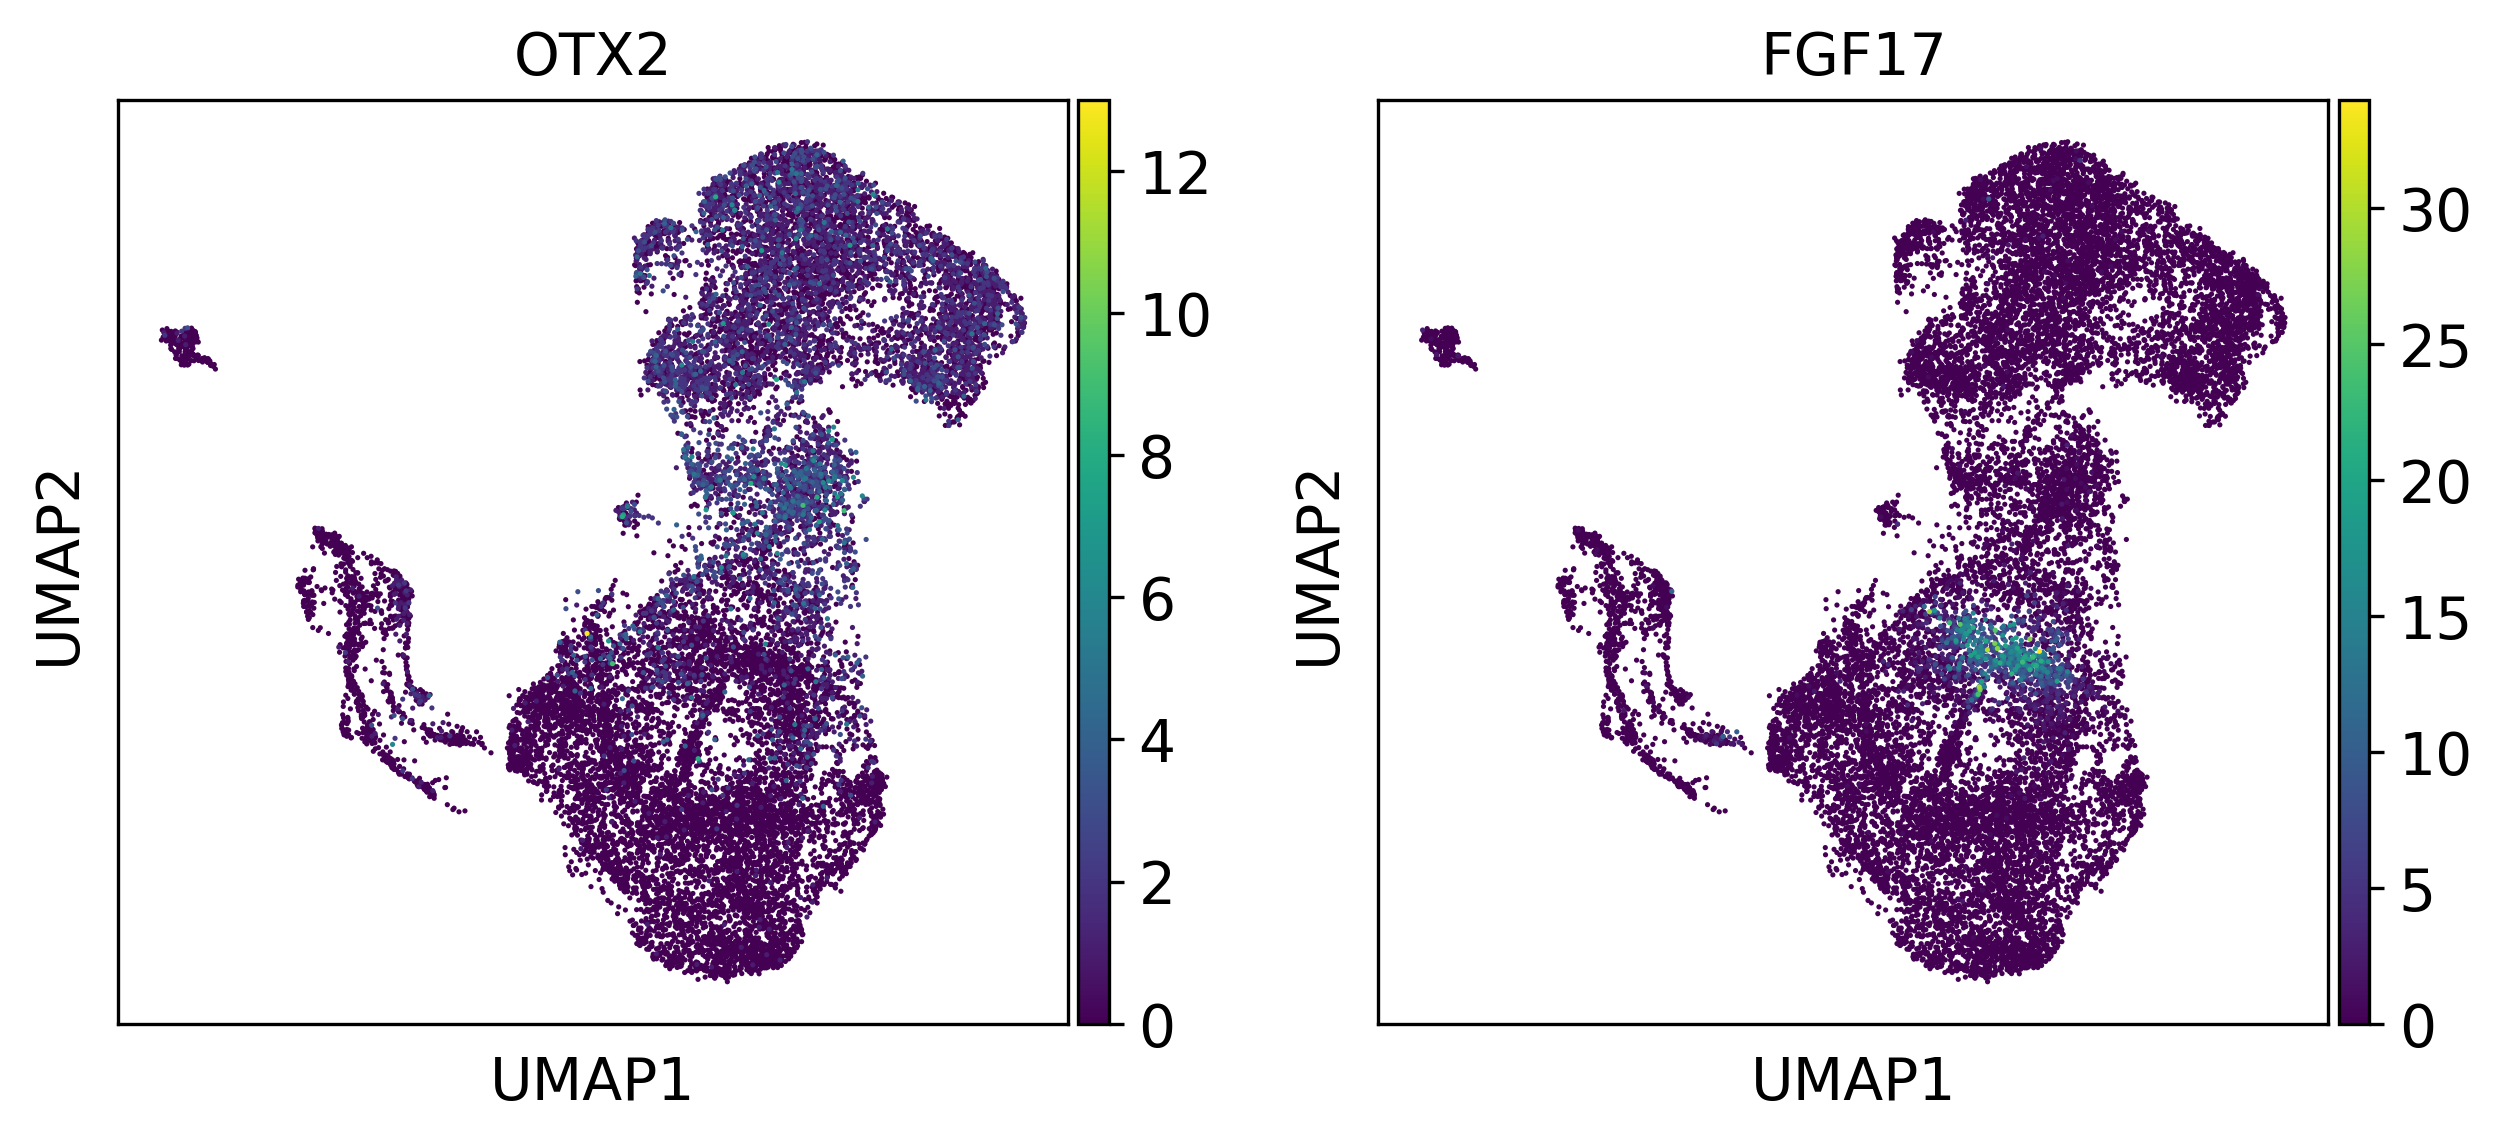

In [20]:
sc.pl.umap(merged, color = ['OTX2','FGF17'])

In [21]:
############write velocity adata for d14d #########
merged.write("/home/kgr851/seurat_data_for_python/velocity/adata/raw/scvi/d14d/d14d.velocity.raw.h5ad")